In [105]:
#importing neccessary modules
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [56]:
# Reading the csv file 'takehome_users.csv' into a dataframe
takehome_users = pd.read_csv('takehome_users.csv',encoding='latin-1')
takehome_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [57]:
# Reading the csv file 'takehome_user_engagement.csv' into a dataframe
takehome_user_engagement=pd.read_csv('takehome_user_engagement.csv')
takehome_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
takehome_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [58]:
#changing the colum name 'object_id' as 'user_id' in dataframe takehome_users
takehome_users.rename(columns={'object_id':'user_id'}, inplace=True)

In [59]:
#converting the to date time object
takehome_user_engagement.time_stamp = pd.to_datetime(takehome_user_engagement.time_stamp)

In [60]:
#to group by date and then count
user_engagements_2 = takehome_user_engagement.set_index('time_stamp').groupby('user_id')['visited'].resample('D').count()

In [61]:
#converting to dataframe
user_engagements_2 = pd.DataFrame(user_engagements_2)

In [62]:
user_engagements_2.head()


visited
user_id time_stamp         
1       2014-04-22        1
2       2013-11-15        1
        2013-11-16        0
        2013-11-17        0
        2013-11-18        0

In [63]:
# Sum number of visits for seven-rolling-day periods.
user_engagements_2 = user_engagements_2.rolling(window=7, min_periods=1).sum()

In [64]:
user_engagements_2.reset_index(inplace=True)

In [65]:
user_engagements_2.head()


,user_id,time_stamp,visited
0,1,2014-04-22,1.0
1,2,2013-11-15,2.0
2,2,2013-11-16,2.0
3,2,2013-11-17,2.0
4,2,2013-11-18,2.0


In [66]:
# Compute max number of visits for each user for seven-rolling-day periods.
user_engagements_3 = user_engagements_2.groupby('user_id')[['visited']].max()

In [67]:
user_engagements_3.head()

,visited
user_id,
1,1.0
2,3.0
3,2.0
4,3.0
5,4.0


In [68]:
# Add target column 'adopted'
user_engagements_3.loc[user_engagements_3['visited'] >= 3, 'adopted_user'] = 1
user_engagements_3.loc[user_engagements_3['visited'] < 3, 'adopted_user'] = 0

In [69]:
# Change data type to 'int'
user_engagements_3['visited'] = user_engagements_3['visited'].astype(int)
user_engagements_3['adopted_user'] = user_engagements_3['adopted_user'].astype(int)

In [70]:
user_engagements_3.reset_index(inplace=True) 

In [71]:
user_engagements_3.head()

,user_id,visited,adopted_user
0,1,1,0
1,2,3,1
2,3,2,0
3,4,3,1
4,5,4,1


In [72]:
# Merge two data frames
df = user_engagements_3.merge(takehome_users, how='inner', on='user_id', sort=True)

In [73]:
df.head()

,user_id,visited,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,3,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,3,1,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,4,1,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [74]:
#checking for null values
df.isnull().sum()

user_id                          0
visited                          0
adopted_user                     0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
dtype: int64

In [75]:
# Fill the invited_by_user_id column's NaN values with 0.
df['invited_by_user_id'].fillna(0, inplace=True)
df['invited_by_user_id'] = df['invited_by_user_id'].astype(int)

In [76]:
# Do some feature engineering
df.creation_time = pd.to_datetime(df.creation_time)
df.last_session_creation_time = pd.to_datetime(df.last_session_creation_time)
df['active_days'] = df['last_session_creation_time'] - df['creation_time']
df['active_days'] = df['active_days'].dt.days

In [77]:
df.head()

,user_id,visited,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days
0,1,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803,-16183
1,2,3,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316,-16025
2,3,2,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525,-15784
3,4,3,1,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151,-15847
4,5,4,1,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240,-15723


In [26]:
df.isnull().sum()

user_id                       0
visited                       0
adopted_user                  0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
active_days                   0
dtype: int64

In [78]:
# Select columns for machine learning algorithms
df_ml = df[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 
              'org_id', 'invited_by_user_id', 'active_days', 'adopted_user' ]]

In [79]:
df_ml.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,adopted_user
0,GUEST_INVITE,1,0,11,10803,-16183,0
1,ORG_INVITE,0,0,1,316,-16025,1
2,ORG_INVITE,0,0,94,1525,-15784,0
3,GUEST_INVITE,0,0,1,5151,-15847,1
4,GUEST_INVITE,0,0,193,5240,-15723,1


In [80]:
# checking for imbalance between the two target classes.
df_ml.adopted_user.value_counts()

1    8015
0     808
Name: adopted_user, dtype: int64

In [81]:
#there is a huge imbalance in data so doing over sampling
X = df_ml.drop(['adopted_user'],axis=1)
Y = df_ml['adopted_user']
ros = RandomOverSampler()
new_x,new_y = ros.fit_resample(X,Y)
df_balanced = new_x
df_balanced['adopted_user'] = new_y

#after sampling
df_balanced.adopted_user.value_counts()


0    8015
1    8015
Name: adopted_user, dtype: int64

In [82]:
#doing OneHotEncode on 'creation_source' column.
df_balanced = pd.get_dummies(df_balanced, columns=['creation_source'])

In [83]:
df_balanced.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
count,16030.000000,16030.000000,16030.000000,16030.00000,16030.000000,16030.000000,16030.000000,16030.000000,16030.000000,16030.000000,16030.000000
mean,0.252589,0.151092,144.686089,3203.32514,-15908.279414,0.500000,0.169931,0.366563,0.083593,0.218465,0.161447
std,0.434511,0.358149,126.351014,3899.40224,215.241907,0.500016,0.375584,0.481881,0.276785,0.413218,0.367954
min,0.000000,0.000000,0.000000,0.00000,-16221.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,29.000000,0.00000,-16101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,110.000000,879.00000,-15931.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,249.000000,6308.00000,-15733.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,416.000000,11999.00000,-15492.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
#Seting Features
x = df_balanced.drop(['adopted_user'],axis=1)
x.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803,-16183,1,0,0,0,0
1,0,0,1,316,-16025,0,1,0,0,0
2,0,0,94,1525,-15784,0,1,0,0,0
3,0,0,1,5151,-15847,1,0,0,0,0
4,0,0,193,5240,-15723,1,0,0,0,0


In [92]:
#Target
y = df_balanced['adopted_user']
y.head()

0    0
1    1
2    0
3    1
4    1
Name: adopted_user, dtype: int32

In [90]:
#Split the data into a train and test sets.
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

In [93]:
# Fit and models and make predictions 

#Random forest
RFC = RandomForestClassifier()
RFC.fit(x_train,y_train)
y_predict_RF = RFC.predict(x_test)

#Logistic Regression
LOG = LogisticRegression()
LOG.fit(x_train,y_train)
y_predicte_LG = LOG.predict(x_test)

In [94]:
# Classification tables

print("Random Forest:") 
print(classification_report(y_test, y_predict_RF))
print('\n')

print("Logistic Regression:") 
print(classification_report(y_test, y_predicte_LG)) 
print('\n')

Random Forest:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2412
           1       1.00      0.93      0.97      2397

    accuracy                           0.97      4809
   macro avg       0.97      0.97      0.97      4809
weighted avg       0.97      0.97      0.97      4809



Logistic Regression:
              precision    recall  f1-score   support

           0       0.52      0.46      0.49      2412
           1       0.51      0.57      0.54      2397

    accuracy                           0.51      4809
   macro avg       0.51      0.51      0.51      4809
weighted avg       0.51      0.51      0.51      4809





In [138]:
# Use Random Forest to evaluate the importance of features on the classification task.
feat_imp = pd.DataFrame({'Importance':RFC.feature_importances_}) 
feat_imp['Importance'] = round(feat_imp['Importance'], 4)
feat_imp['Feature'] = x_train.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
print("Features sorted by their score:")
feat_imp

Features sorted by their score:


,Importance,Feature
4,0.4081,active_days
2,0.3628,org_id
3,0.1738,invited_by_user_id
0,0.0174,opted_in_to_mailing_list
1,0.0150,enabled_for_marketing_drip
5,0.0052,creation_source_GUEST_INVITE
6,0.0047,creation_source_ORG_INVITE
7,0.0044,creation_source_PERSONAL_PROJECTS
8,0.0044,creation_source_SIGNUP
9,0.0042,creation_source_SIGNUP_GOOGLE_AUTH


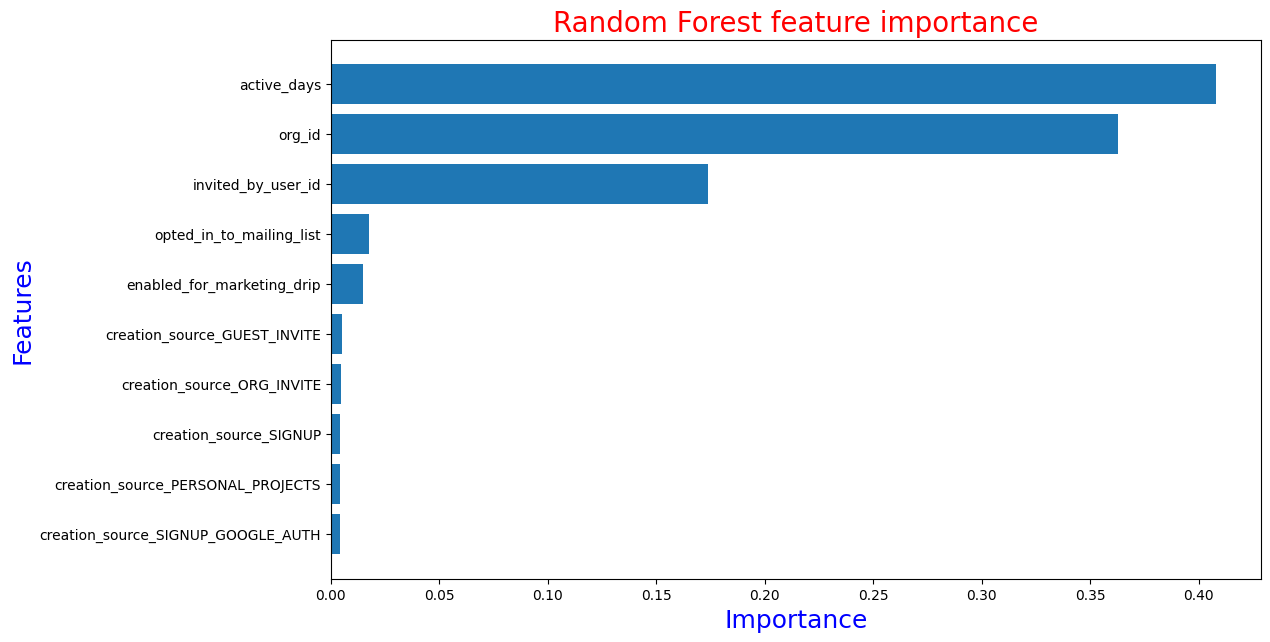

In [147]:
#Ploting a bar graph on Random Forest feature importance
feat_imp.sort_values(by='Importance', inplace=True)
plt.figure(figsize = (12,7))

x = feat_imp['Importance']
y = feat_imp['Feature']
plt.barh(y, x)
 
# setting label of y-axis
plt.ylabel("Features",fontsize=18).set_color('BLUE') 
 
# setting label of x-axis
plt.xlabel("Importance",fontsize=18).set_color('BLUE')

plt.title("Random Forest feature importance",fontsize=20).set_color('RED')
plt.show()

### The most important features to predict future user adoption are :

1. number of 'active days' (difference between last login date and creation date)
2. org_id: the organization (group of users) they belong to
3. invited_by_user_id: which user invited them to join.
4. opted_in_to_mailing_list :whether they have opted into receiving marketing emails
5. enabled_for_marketing_drip : whether they are on the regular marketing email drip